# Time Series Modeling Exercises
***

#### Using saas.csv or log data from API usage or store_item_sales

1. Split data (train/validate/test) and resample by any period, except daily, and aggregate using the sum.
2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
    - Simple Average
    - Moving Average
    - Holt's Linear Trend Model
    - Based on previous year/month/etc., this is up to you.
    - Optional: Using store item demand
    

3. Predict 2018 total monthly sales for a single store and/or item by creating a model.
    - Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper).
    
    
4. Plot the 2018 monthly sales predictions.

In [1]:
import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")

# Acquire 

In [2]:
#Read local .csv downloaded from CodeUp notebook
df = pd.read_csv('saas.csv')
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


# Prepare

In [3]:
#check for nulls
df.isna().sum()

Month_Invoiced       0
Customer_Id          0
Invoice_Id           0
Subscription_Type    0
Amount               0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month_Invoiced     790458 non-null  object 
 1   Customer_Id        790458 non-null  int64  
 2   Invoice_Id         790458 non-null  int64  
 3   Subscription_Type  790458 non-null  float64
 4   Amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


In [5]:
# Month_Invoiced to datetime
df = df.assign(ds = pd.to_datetime(df.Month_Invoiced))

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Month_Invoiced     790458 non-null  object        
 1   Customer_Id        790458 non-null  int64         
 2   Invoice_Id         790458 non-null  int64         
 3   Subscription_Type  790458 non-null  float64       
 4   Amount             790458 non-null  float64       
 5   ds                 790458 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 36.2+ MB


In [7]:
# sort values by date
df.sort_values('ds')

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount,ds
0,2014-01-31,1000000,5000000,0.0,0.0,2014-01-31
13336,2014-01-31,1013336,5013336,0.0,0.0,2014-01-31
13335,2014-01-31,1013335,5013335,0.0,0.0,2014-01-31
13334,2014-01-31,1013334,5013334,0.0,0.0,2014-01-31
13333,2014-01-31,1013333,5013333,1.0,5.0,2014-01-31
...,...,...,...,...,...,...
781185,2017-12-31,1012069,5781185,0.0,0.0,2017-12-31
781186,2017-12-31,1012072,5781186,0.0,0.0,2017-12-31
781187,2017-12-31,1012074,5781187,1.0,5.0,2017-12-31
781176,2017-12-31,1012047,5781176,3.0,15.0,2017-12-31


In [8]:
df.tail(1)

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount,ds
790457,2017-12-31,1029399,5790457,0.0,0.0,2017-12-31


In [9]:
# set index - didn't have to do this
df = df.set_index('ds')

In [10]:
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
ds,,,,,
2014-01-31,2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,2014-01-31,1000001,5000001,2.0,10.0
2014-01-31,2014-01-31,1000002,5000002,0.0,0.0
2014-01-31,2014-01-31,1000003,5000003,0.0,0.0
2014-01-31,2014-01-31,1000004,5000004,1.0,5.0


In [11]:
df['daily_total'] = df.groupby(['ds'])[['Amount']].sum()

In [12]:
df.columns

Index(['Month_Invoiced', 'Customer_Id', 'Invoice_Id', 'Subscription_Type',
       'Amount', 'daily_total'],
      dtype='object')

In [13]:
df = df.drop(columns=['Month_Invoiced', 'Customer_Id', 'Invoice_Id', 'Subscription_Type','Amount'])
df.head()

,daily_total
ds,
2014-01-31,35850.0
2014-01-31,35850.0
2014-01-31,35850.0
2014-01-31,35850.0
2014-01-31,35850.0


# Split

In [14]:
df.index.min(), df.index.max()

(Timestamp('2014-01-31 00:00:00'), Timestamp('2017-12-31 00:00:00'))

In [15]:
df_size = len(df)
df_size

790458

In [16]:
# compute num of rows that are 50% of total rows and assign to variable train_size
train_size = int(len(df) * 0.5)
train_size

395229

In [17]:
# compute num of rows that are 30% of total rows and assign to variable validate_size
validate_size = int(len(df) * .3)
validate_size

237137

In [18]:
# make test_size the number of rows remaining (test_size = total # of rows - train_size - validate_size)
test_size = int(len(df) - train_size - validate_size)
test_size

158092

In [19]:
# compute the row number at which the switch from validate to test happens. 
validate_end_index = train_size + validate_size
validate_end_index

632366

In [20]:
# split into train, validation, test
train = df[: train_size]

validate = df[train_size : validate_end_index]

test = df[validate_end_index : ]

test.tail(1)

,daily_total
ds,
2017-12-31,53805.0


In [21]:
#Verify splits
# sum of train, validate and test = total number of rows? 
len(train) + len(validate) + len(test) == len(df)

True

In [22]:
#Does first row of original df equal to first row of train
# test the row starts
print(df.head(1) == train.head(1))

            daily_total
ds                     
2014-01-31         True


In [23]:
# test the split between validate and test
pd.concat([train.tail(1), validate.head(1)])

,daily_total
ds,
2015-10-31,51445.0
2015-10-31,51445.0


In [24]:
pd.concat([validate.tail(1), test.head(1)])

,daily_total
ds,
2017-01-31,53395.0
2017-01-31,53395.0


In [25]:
# compare the last row of test to last row of df
pd.concat([test.tail(1), df.tail(1)])

,daily_total
ds,
2017-12-31,53805.0
2017-12-31,53805.0


In [26]:
train.columns

Index(['daily_total'], dtype='object')

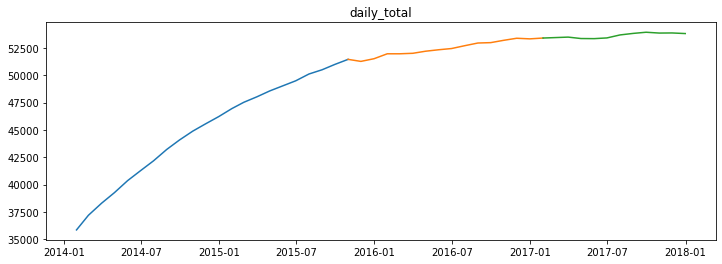

In [27]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.title(col)
    plt.show()

In [28]:
# define evaluation function to compute rmse

def evaluate(target_var):
    '''
    the evaluate function will take in the actual values in validate and the predicted values
    and compute the mean_squared_error and then take the square root and round to 0 decimals.
    It will return the rmse, an integer.
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])),0)
    return rmse

In [29]:
def plot_samples(target_var):
    '''
    this function will plot the train, validate, and test values for a single variable 
    across all dates. 
    '''
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var])
    plt.plot(validate[target_var])
    plt.plot(test[target_var])
    plt.title(target_var)
#    plt.show()

In [30]:
# plot and evaluate: plot
def plot_and_eval(target_var):
    '''
    a function to evaluate forecasts by computing the rmse and plot train and validate along with predictions
    '''
    plot_samples(target_var)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '--RMSE: {:.0f}'.format(rmse))
    plt.show()

In [31]:
# Create the empty dataframe with model_type, target_var, rmse
eval_df = pd.DataFrame(columns = ['model_type', 'target_var', 'rmse'])



In [32]:
# check out the data frame
eval_df

,model_type,target_var,rmse


In [33]:
# Define function to store rmse for comparison purposes

def append_eval_df(model_type, target_var):
    '''
    this function is going to take in the model_type as a string, the target variable as a string,
    and run the evaluate() function to compute the rmse, and append to the data frame a row
    with the model_type, target_var, and rmse.  It will return the new dataframe.
    '''
    rmse = evaluate(target_var)

    d = {'model_type': [model_type], 'target_var': [target_var],'rmse':[rmse]}
    d = pd.DataFrame(d)
    
    return eval_df.append(d, ignore_index=True)
    

# Forecast

In [34]:
# create var 'items' with last observed value
#items = train['items_sold'][-1][0] 

dt = train['daily_total'][-1]
dt

51445.0

In [35]:
# make predictions by adding those values to new dataframe yhat_df
yhat_df = pd.DataFrame({'daily_total':[dt]}, index = validate.index)

yhat_df.head(2)

,daily_total
ds,
2015-10-31,51445.0
2015-10-31,51445.0


daily_total --RMSE: 1220


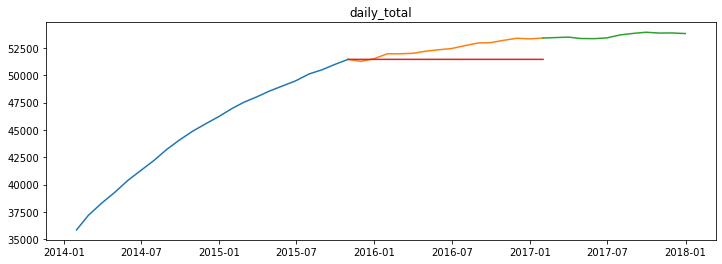

In [36]:
plot_and_eval('daily_total')

In [37]:
#Evaluate
eval_df = append_eval_df(model_type = 'last_observed_value', target_var = 'daily_total')

In [38]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,daily_total,1220.0


### Simple Average

In [39]:
#Simple Average
dt = round(train['daily_total'].mean(), 2)
yhat_df = pd.DataFrame({'daily_total':[dt]}, index = validate.index)
yhat_df

,daily_total
ds,
2015-10-31,44706.32
2015-10-31,44706.32
2015-10-31,44706.32
2015-10-31,44706.32
2015-10-31,44706.32
...,...
2017-01-31,44706.32
2017-01-31,44706.32
2017-01-31,44706.32


daily_total --RMSE: 7784


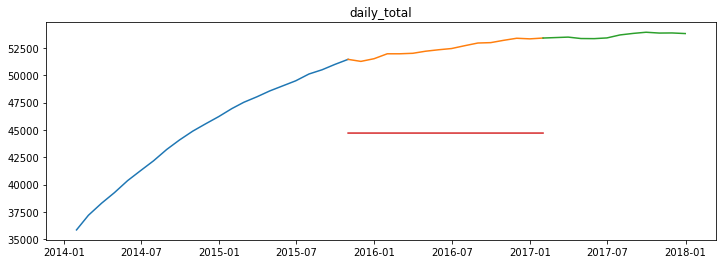

In [40]:
plot_and_eval('daily_total')

In [41]:
eval_df = append_eval_df(model_type = 'simple_average', target_var = 'daily_total')
eval_df

,model_type,target_var,rmse
0,last_observed_value,daily_total,1220.0
1,simple_average,daily_total,7784.0


### Moving Average

In [42]:
period = 30 
#use the rolling method, take the rolling mean of 30 days, and select the last value, 
#i.e. the last day in train
#round to two decimals and do that for each target variable
dt = round(train['daily_total'].rolling(period).mean().iloc[-1], 0)
yhat_df = pd.DataFrame({'daily_total':[dt]}, index = validate.index)
yhat_df

,daily_total
ds,
2015-10-31,51445.0
2015-10-31,51445.0
2015-10-31,51445.0
2015-10-31,51445.0
2015-10-31,51445.0
...,...
2017-01-31,51445.0
2017-01-31,51445.0
2017-01-31,51445.0


daily_total --RMSE: 1220


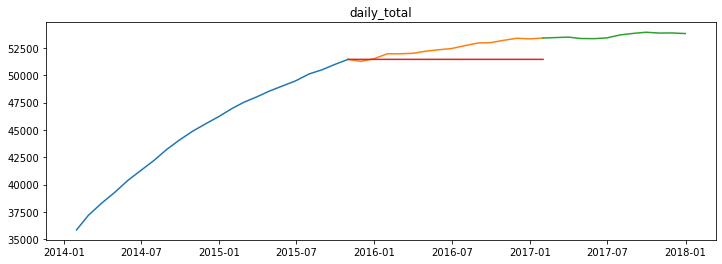

In [43]:
plot_and_eval('daily_total')

In [44]:
eval_df = append_eval_df(model_type = '30day moving average', target_var = 'daily_total')
eval_df

,model_type,target_var,rmse
0,last_observed_value,daily_total,1220.0
1,simple_average,daily_total,7784.0
2,30day moving average,daily_total,1220.0


### Holt's Linear Trend

In [45]:
model = Holt(train['daily_total'], exponential = False)
model = model.fit(smoothing_level = .1, 
                    smoothing_slope = .1, 
                    optimized = False)


In [46]:
validate.index[0]

Timestamp('2015-10-31 00:00:00')

In [47]:
yhat_dt = model.predict(start = validate.index[0], 
                        end = validate.index[-1])
yhat_df['daily_total'] = round(yhat_dt, 2)

KeyError: 'The `end` argument could not be matched to a location related to the index of the data.'

In [ ]:
col = 'daily_total'
# create the Holt object 
model = Holt(train[col], exponential=False, damped=True)
# fit the model 
model = model.fit(optimized=True)
# make predictions for each date in validate 
yhat_items = model.predict(start = validate.index[0],
                           end = validate.index[-1])
# add predictions to yhat_df
yhat_df[col] = round(yhat_items, 2)

### Predict Based on Previous Cycle

In [48]:
#Resplit data
train = df[:'2015']
validate = df['2016']
test = df['2017']

In [49]:
#Make predictions
yhat_df = train['2015'] + train.diff(365).mean()

In [50]:
pd.concat([yhat_df.head(1), validate.head(1)])

,daily_total
ds,
2015-01-31,46958.241462
2016-01-31,51955.000000


In [51]:
# set yhat_df to index of validate
yhat_df.index = validate.index

len(yhat_df)

ValueError: Length mismatch: Expected axis has 204352 elements, new values have 186275 elements

ValueError: Found input variables with inconsistent numbers of samples: [186275, 204352]

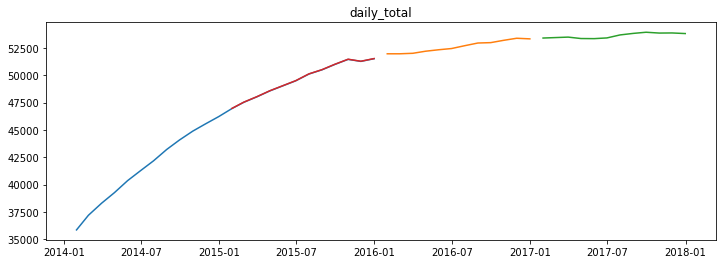

In [52]:
plot_and_eval('daily_total')
eval_df = append_eval_df(model_type = 'previous year', target_var = 'daily_total')

In [53]:
#Which model performed best
# get the min rmse for each variable

min_rmse_dollars_sold = eval_df.groupby('target_var')['rmse'].min()[0]
min_rmse_items_sold = eval_df.groupby('target_var')['rmse'].min()[1]

# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[((eval_df.rmse == min_rmse_dollars_sold) | 
         (eval_df.rmse == min_rmse_items_sold)
        )]

IndexError: index 1 is out of bounds for axis 0 with size 1

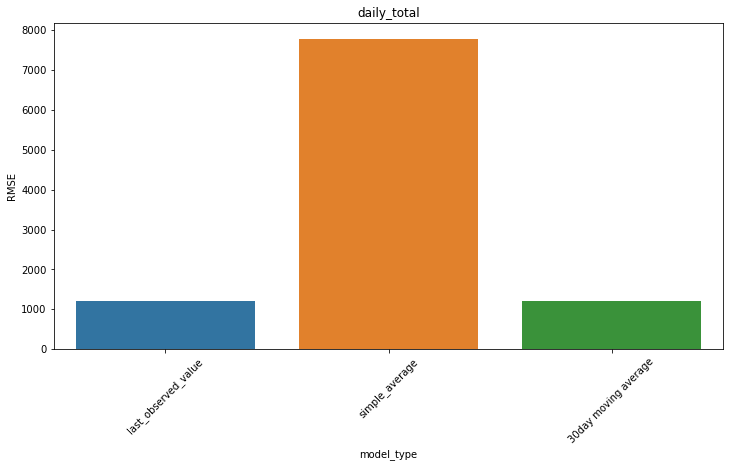

In [54]:
#Plot model comparison
x = eval_df[eval_df.target_var == 'daily_total']['model_type']
y = eval_df[eval_df.target_var == 'daily_total']['rmse']
plt.figure(figsize=(12, 6))
sns.barplot(x, y)
plt.title(col)
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.show()